In [69]:
# STEINMETZ PREPROCESSING

In [70]:
# Set up

# Import packages
import os, requests
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd

# Download and load data 
from data.get_data import load,download

download()


# Load data
alldat = load()


Loading data. Patience, padawan ...


In [71]:
# DataFrame setup

# print DataFrame shape
print('alldat Shape:', alldat.shape)
print('')

# Total number of sessions in Steinmetz datasent, i.e. the len of 'alldat'
print('Total # of sessions in Steinmetz dataset:', len(alldat)) #len of 'alldat'
print('')

# Some basic information about alldat (mouse name and session quant)

# Mouse name and session # in "alldat"
print('Mouse name and session # in "alldat":')
for i in range(len(alldat)):
    session = alldat[i]
    print('Session #: %s'%(i))
    print('Mouse name: %s'%(session['mouse_name']))

# Isolate a single session for mouse name: 
# session = 0 
# print('Mouse name: %s'%(alldat[session]['mouse_name']))


alldat Shape: (39,)

Total # of sessions in Steinmetz dataset: 39

Mouse name and session # in "alldat":
Session #: 0
Mouse name: Cori
Session #: 1
Mouse name: Cori
Session #: 2
Mouse name: Cori
Session #: 3
Mouse name: Forssmann
Session #: 4
Mouse name: Forssmann
Session #: 5
Mouse name: Forssmann
Session #: 6
Mouse name: Forssmann
Session #: 7
Mouse name: Hench
Session #: 8
Mouse name: Hench
Session #: 9
Mouse name: Hench
Session #: 10
Mouse name: Hench
Session #: 11
Mouse name: Lederberg
Session #: 12
Mouse name: Lederberg
Session #: 13
Mouse name: Lederberg
Session #: 14
Mouse name: Lederberg
Session #: 15
Mouse name: Lederberg
Session #: 16
Mouse name: Lederberg
Session #: 17
Mouse name: Lederberg
Session #: 18
Mouse name: Moniz
Session #: 19
Mouse name: Moniz
Session #: 20
Mouse name: Moniz
Session #: 21
Mouse name: Muller
Session #: 22
Mouse name: Muller
Session #: 23
Mouse name: Muller
Session #: 24
Mouse name: Radnitz
Session #: 25
Mouse name: Radnitz
Session #: 26
Mouse name:

In [72]:
# Extract just one session

session = 12

dat = alldat[session]
print('keys in dat:', dat.keys())
print('')

# How many trials in this session?
print('Number of trials in session #%s' %session, len(dat['response']))

# Every DataFrame going forward should have # of trials quantity of rows


keys in dat: dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])

Number of trials in session #12 300


In [73]:
# Step 0: Foundational DataFrame

# Create 1 column df of len (quantity of trials in that session) filled with session #

empty = np.empty([len(dat['gocue']), 1])

for i in range(len(empty)):
    empty[i] = session

session_df = pd.DataFrame(empty)
session_df = session_df.rename(columns={0: 'session'}).astype(str)
print('session df shape:', session_df.shape)

session_df.head()

# Create 1 column df of len (quantity of trials in that session) filled with session's mouse name

empty_b = np.empty([len(dat['gocue']), 1]).astype(str)

for i in range(len(empty_b)):
    mouse_name = alldat[session]['mouse_name']
    empty_b[i] = mouse_name

mouse_name_df = pd.DataFrame(empty_b)
mouse_name_df = mouse_name_df.rename(columns={0: 'mouse_name'})
print('mouse_name df shape:', mouse_name_df.shape)

mouse_name_df.head()

# Create first DataFrame to apped all desired data to (should have session # and mouse name to start, where each row is a trial)

foundation = pd.concat([session_df, mouse_name_df], axis = 1)
foundation.head()


session df shape: (300, 1)
mouse_name df shape: (300, 1)


,session,mouse_name
0,12.0,Lederberg
1,12.0,Lederberg
2,12.0,Lederberg
3,12.0,Lederberg
4,12.0,Lederberg


In [74]:
# Step 1: Extract information about every trial in given session
# Trials (trial_type)

# Make a list to define range in for loop 
# Session columns related to stimulus contrast: dat['contrast_right'] and dat['contrast_left'] hold contrast values (0, .25, .5, 1.0) 
contrast_trials = {'contrast_right': dat['contrast_right'], 'contrast_left': dat['contrast_left']}
contrast_trials = pd.DataFrame(contrast_trials)
print('contrast_trials df shape:', contrast_trials.shape)

# Define trial_type_func, a function to determine trial_type from session's contrast columns
def trial_type_func (row):
    if row['contrast_left'] == 0 and row['contrast_right'] != 0:
        trial_type = 'A'
        return trial_type
    elif row['contrast_left'] != 0 and row['contrast_right'] == 0:
        trial_type = 'B'
        return trial_type
    elif row['contrast_right'] or row['contrast_left'] != 0 and row['contrast_right'] > row['contrast_left']:
        trial_type = 'C'
        return trial_type
    elif row['contrast_right'] or row['contrast_left'] != 0 and row['contrast_right'] < row['contrast_left']:
        trial_type = 'D'
        return trial_type
    elif row['contrast_left'] == 0 and row['contrast_right'] == 0:
        trial_type = 'E'
        return trial_type
    else:
        return 'NaN'

# Define stim_loc_func function to take in session's contrast columns and determine stimulus location for the trial (row or index pos)
def stim_loc_func (row):
    if row['contrast_left'] == 0:                                                                              # stim on right
        stim_loc = -1.
        return stim_loc
    elif row['contrast_right'] == 0:                                                                           # stim on left
        stim_loc = 1.
        return stim_loc
    elif row['contrast_right'] or row['contrast_left'] != 0 and row['contrast_right'] > row['contrast_left']:
        stim_loc = 2.
        return stim_loc
    elif row['contrast_right'] or row['contrast_left'] != 0 and row['contrast_right'] < row['contrast_left']:
        stim_loc = 2.
        return stim_loc
    elif row['contrast_left'] == 0 and row['contrast_right'] == 0:
        stim_loc = 0.
        return stim_loc
    else:
        return 'NaN'

# Define winning_stim_func to take in session's contrast columns and determine side of higher/winning stimulus contrast for each trial(row or index pos)
def winning_stim_func (row):
    if row['contrast_left'] == 0 and row['contrast_right'] != 0:
        winning_stim = {'right': -1.}
        return winning_stim
    elif row['contrast_right'] == 0 and row['contrast_left'] != 0:
        winning_stim = {'left': 1.}
        return winning_stim
    elif row['contrast_right'] or row['contrast_left'] != 0 and row['contrast_right'] > row['contrast_left']:
        winning_stim = {'right': -1.}
        return winning_stim
    elif row['contrast_right'] or row['contrast_left'] != 0 and row['contrast_right'] < row['contrast_left']:
        winning_stim = {'left': 1.}
        return winning_stim
    elif row['contrast_left'] == 0 and row['contrast_right'] == 0:
        winning_stim = {'no-go': 0.}
        return winning_stim
    else:
        return 'NaN'

# Apply trial_type_func to session's contrast columns to determine trial type of each trial (row or index pos)
trial_type = contrast_trials.apply(lambda row: trial_type_func(row), axis=1)
trial_type = pd.DataFrame(trial_type)
trial_type = trial_type.rename(columns={0: 'trial_type'})
print('trial_type df shape:', trial_type.shape)

# Apply stim_loc_func to session's contrast columns to determine stimulus location for the trial (row or index pos)
stim_loc = contrast_trials.apply(lambda row: stim_loc_func(row), axis=1)
stim_loc = pd.DataFrame(stim_loc)
stim_loc = stim_loc.rename(columns={0: 'stim_loc'})
print('stim_loc df shape:', stim_loc.shape)

# Apply winning_stim_func to session's contrast columns to determine side of higher/winning stimulus contrast for each trial(row or index pos)
winning_stim = contrast_trials.apply(lambda row: winning_stim_func(row), axis=1)
winning_stim = pd.DataFrame(winning_stim)
winning_stim = winning_stim.rename(columns={0: 'winning_stim'})
print('winning_stim df shape:', winning_stim.shape)

# Concat created dfs into one dataframe (s1 = Step 1)
# trials_s1 = every row is a trial and this has every column associated with Step 1 (trial type and stim information)
trials_s1 = pd.concat([foundation, trial_type, contrast_trials, stim_loc, winning_stim], axis = 1)
print('trials_s1 shape:', trials_s1.shape)
print('')

# Make sure all dfs have the same length
if len(contrast_trials) == len(trial_type) == len(winning_stim) == len(trials_s1):
    print('woohoo! all dfs have same len! you are chillin bb')
print('')

# Check trial_type_fin for correct column names
trials_s1.head()


contrast_trials df shape: (300, 2)
trial_type df shape: (300, 1)
stim_loc df shape: (300, 1)
winning_stim df shape: (300, 1)
trials_s1 shape: (300, 7)

woohoo! all dfs have same len! you are chillin bb



,session,mouse_name,trial_type,contrast_right,contrast_left,stim_loc,winning_stim
0,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0}
1,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0}
2,12.0,Lederberg,B,0.0,0.5,1.0,{'left': 1.0}
3,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0}
4,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0}


In [75]:
# Step 2: Extracting accuracy information for every trial in the session
#Accuracy (ideal_resp, acc_prev, acc_pres)

# Accuracy of present trial (t0) (acc_pres)

# Make a list to define range in for loop 
m_resp_list = {'mouse_resp': dat['response']}
m_resp_df = pd.DataFrame(m_resp_list)
print('m_resp_df shape:', m_resp_df.shape)

# Define trial_ideal_func, a function to determine what the ideal response would be given trial type
# Accuracy integers defined by Steinmetz
def trial_ideal_func (row):
    if row['trial_type'] == 'A': 
        correct_resp = -1.
        return correct_resp 
    elif row['trial_type'] == 'B':
        correct_resp = 1.
        return correct_resp 
    elif row['trial_type'] == 'C':
        correct_resp = -1.
        return correct_resp
    elif row['trial_type'] == 'D':
        correct_resp = 1.
        return correct_resp
    elif row['trial_type'] == 'E':
        correct_resp = 0.
        return correct_resp
    else:
        return 'error in trial_acc_func'

# Define trial_acc_func, a function to determine if mouse was right(1) or wrong(0) on the present trial
def trial_acc_func (row):
    if row['mouse_resp'] == row['ideal_resp']: 
        m_acc = 1.
        return m_acc 
    else:
        m_acc = 0.
        return m_acc

# Apply trial_ideal_func to determine what a 'correct' or 'ideal' response would be on the present trial
ideal_resp = trials_s1.apply(lambda row: trial_ideal_func(row), axis=1)
ideal_resp = pd.DataFrame(ideal_resp)
ideal_resp = ideal_resp.rename(columns={0: 'ideal_resp'})
print('ideal_resp df shape:', ideal_resp.shape)
trials_s2_a= pd.concat([trials_s1, m_resp_df, ideal_resp], axis = 1)

# Apply trial_acc_func to determine if mouse was correct in present trial
pres_acc = trials_s2_a.apply(lambda row: trial_acc_func(row), axis=1)
pres_acc = pd.DataFrame(pres_acc)
pres_acc = pres_acc.rename(columns={0: 'pres_acc'})
print('pres_acc df shape:', pres_acc.shape)

# Combine all dfs so far into one df for further investigation
trials_s2_b= pd.concat([trials_s2_a, pres_acc], axis = 1)

# Previous accuracy (acc_prev)
# Create an empty array to assign previous accuracy values to
empty = np.empty([len(dat['response']), 1])
empty[0] = 'NaN' #ignore first index because there is no previous trial to this index

for i in range(len(empty)-1):
    empty[i+1] = trials_s2_b['pres_acc'][i]

prev_acc = pd.DataFrame(empty)
prev_acc = prev_acc.rename(columns={0: 'prev_acc'})
print('prev_acc df shape:', prev_acc.shape)

# Combine all new dfs into one (s2 = Step 2)
trials_s2= pd.concat([trials_s2_a, prev_acc, pres_acc], axis = 1)
print('trials_s2 df shape:', trials_s2.shape)
print('')

# Make sure all dfs have the same length
if len(m_resp_df) == len(trials_s2_a) ==  len(prev_acc) == len(pres_acc) == len(trials_s2):
    print('woohoo! all dfs have same len! you are chillin bb')
print('')

# Check trial_type_fin for correct column names
trials_s2.head()


m_resp_df shape: (300, 1)
ideal_resp df shape: (300, 1)
pres_acc df shape: (300, 1)
prev_acc df shape: (300, 1)
trials_s2 df shape: (300, 11)

woohoo! all dfs have same len! you are chillin bb



,session,mouse_name,trial_type,contrast_right,contrast_left,stim_loc,winning_stim,mouse_resp,ideal_resp,prev_acc,pres_acc
0,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},-1.0,0.0,NaN,0.0
1,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,0.0,1.0
2,12.0,Lederberg,B,0.0,0.5,1.0,{'left': 1.0},1.0,1.0,1.0,1.0
3,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,1.0,1.0
4,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,1.0,1.0


In [76]:
# Step 3: Assessing contrast differences and difficulty (contrast_diff, abs_contrast_diff, prev_difficulty, pres_difficulty)

# Determine contrast difference between left and right for each trial 

# Define trial_contrast_diff, a function to assess contrast difference between left and right stimulus on a given trial (even when just one appears)
def trial_contrast_diff (row):
    contrast_diff = row['contrast_left'] - row['contrast_right']
    return contrast_diff 

# Define trial_contrast_abs_diff, a function to assess the absolute value of contrast difference between left and right stimulus on a given trial (even when just one appears)
def trial_contrast_abs_diff (row):
    abs_contrast_diff = np.abs(row['contrast_left'] - row['contrast_right'])
    return abs_contrast_diff 

# Apply trial_contrast_diff to determine contrast difference on every trial (contrast_diff)
contrast_diff = trials_s2.apply(lambda row: trial_contrast_diff(row), axis=1)
contrast_diff = pd.DataFrame(contrast_diff)
contrast_diff = contrast_diff.rename(columns={0: 'contrast_diff'})
print('contrast_diff df shape:', contrast_diff.shape)

# Apply trial_contrast_abs_diff to determine absolute contrast difference on every trial (abs_contrast_diff)
abs_contrast_diff = trials_s2.apply(lambda row: trial_contrast_abs_diff(row), axis=1)
abs_contrast_diff = pd.DataFrame(abs_contrast_diff)
abs_contrast_diff = abs_contrast_diff.rename(columns={0: 'abs_contrast_diff'})
print('abs_contrast_diff df shape:', abs_contrast_diff.shape)


# Combine dataframes up to this point into one for further assessment
trials_s3_a = pd.concat([trials_s2, contrast_diff, abs_contrast_diff], axis = 1)
print('trials_s3_a df shape:', trials_s3_a.shape)
print('')


# Define trial_difficulty, a function to determine the difficulty for the present/current trial (1 - abs(left - right contrast))
def trial_difficulty(row):
    difficulty = 1 - np.abs(row['contrast_left'] - row['contrast_right'])
    return difficulty

# Apply trial_difficulty to append a column holding present/current trial difficulty (pres_difficulty)
pres_difficulty = trials_s3_a.apply(lambda row: trial_difficulty(row), axis=1)
pres_difficulty = pd.DataFrame(pres_difficulty)
pres_difficulty = pres_difficulty.rename(columns={0: 'pres_difficulty'})
print('pres_difficulty df shape:', pres_difficulty.shape)


# Combine dataframes up to this point again for further assessment
trials_s3_b = pd.concat([trials_s3_a, pres_difficulty], axis = 1)


# Determine the difficulty from previous trial for every row (prev_difficulty)

# Create an empty array to fill in with previous difficulty scores for every row (trial)
empty = np.empty([len(dat['response']), 1])
empty[0] = 'NaN' #ignore first index because there is no previous trial to this index

for i in range(len(empty)-1):
    empty[i+1] = trials_s3_b['pres_difficulty'][i]

prev_difficulty = pd.DataFrame(empty)
prev_difficulty = prev_difficulty.rename(columns={0: 'prev_difficulty'})
print('prev_difficulty df shape:', prev_difficulty.shape)

# Combine all dfs into one for a final Step 3 (s3) DataFrame
trials_s3 = pd.concat([trials_s2, trials_s3_b, prev_difficulty], axis = 1)
print('trials_s3 df shape:', trials_s3.shape)
print('')

# Make sure all dfs have the same length
if len(contrast_diff) == len(abs_contrast_diff) ==  len(trials_s3_b) == len(prev_difficulty) == len(trials_s3):
    print('woohoo! all dfs have same len! you are chillin bb')
print('')

trials_s3.head()

contrast_diff df shape: (300, 1)
abs_contrast_diff df shape: (300, 1)
trials_s3_a df shape: (300, 13)

pres_difficulty df shape: (300, 1)
prev_difficulty df shape: (300, 1)
trials_s3 df shape: (300, 26)

woohoo! all dfs have same len! you are chillin bb



,session,mouse_name,trial_type,contrast_right,contrast_left,stim_loc,winning_stim,mouse_resp,ideal_resp,prev_acc,...,stim_loc,winning_stim,mouse_resp,ideal_resp,prev_acc,pres_acc,contrast_diff,abs_contrast_diff,pres_difficulty,prev_difficulty
0,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},-1.0,0.0,NaN,...,-1.0,{'no-go': 0.0},-1.0,0.0,NaN,0.0,0.0,0.0,1.0,NaN
1,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,0.0,...,-1.0,{'no-go': 0.0},0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,12.0,Lederberg,B,0.0,0.5,1.0,{'left': 1.0},1.0,1.0,1.0,...,1.0,{'left': 1.0},1.0,1.0,1.0,1.0,0.5,0.5,0.5,1.0
3,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,1.0,...,-1.0,{'no-go': 0.0},0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.5
4,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,1.0,...,-1.0,{'no-go': 0.0},0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0


In [77]:
# Step 4: Crucial time points
# Time points (go_onset, resp_time)

# Go cue onset
go_onset = pd.DataFrame(dat['gocue'])
go_onset = go_onset.rename(columns={0: 'gocue_onset'})
print('go_onset df shape:', go_onset.shape)
print('')

# Response time
resp_time = pd.DataFrame(dat['response_time'])
resp_time = resp_time.rename(columns={0: 'resp_time'})
print('resp_time df shape:', resp_time.shape)
print('')

# Combine dataframes into one cumulative df adding s4 (step 4)
trials_s4_a = pd.concat([trials_s3, go_onset, resp_time], axis = 1)
print('trials_s4_a df shape:', trials_s4_a.shape)
print('')

# Latency calculation

# Define latency_func, a function to determine the latency between rt and go cue 
def latency_func(row):
    latency = row['resp_time'] - row['gocue_onset']
    return latency

# Apply trial_difficulty to append a column holding present/current trial difficulty (pres_difficulty)
latency = trials_s4_a.apply(lambda row: latency_func(row), axis=1)
latency = pd.DataFrame(latency)
latency = latency.rename(columns={0: 'latency'})
print('latency df shape:', latency.shape)
print('')

# Combine dataframes into one cumulative df adding s4 (step 4)
trials_s4 = pd.concat([trials_s4_a, latency], axis = 1)
print('trials_s4 df shape:', trials_s4.shape)
print('')

# Make sure all dfs have the same length
if len(go_onset) == len(resp_time) == len(trials_s4_a) == len(trials_s4):
    print('woohoo! all dfs have same len! you are chillin bb')
print('')

trials_s4.head()

go_onset df shape: (300, 1)

resp_time df shape: (300, 1)

trials_s4_a df shape: (300, 28)

latency df shape: (300, 1)

trials_s4 df shape: (300, 29)

woohoo! all dfs have same len! you are chillin bb



,session,mouse_name,trial_type,contrast_right,contrast_left,stim_loc,winning_stim,mouse_resp,ideal_resp,prev_acc,...,ideal_resp,prev_acc,pres_acc,contrast_diff,abs_contrast_diff,pres_difficulty,prev_difficulty,gocue_onset,resp_time,latency
0,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},-1.0,0.0,NaN,...,0.0,NaN,0.0,0.0,0.0,1.0,NaN,0.544450,0.732127,0.187677
1,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.548057,2.048069,1.500012
2,12.0,Lederberg,B,0.0,0.5,1.0,{'left': 1.0},1.0,1.0,1.0,...,1.0,1.0,1.0,0.5,0.5,0.5,1.0,0.593165,0.830966,0.237801
3,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.5,0.668705,2.181737,1.513032
4,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.676872,2.176100,1.499228


(250, 1)


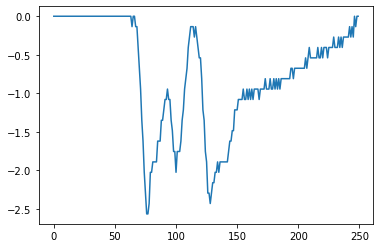

In [85]:
# Step 5: Extract wheel location and speed (wheel_speed)
# dat['wheel'] holds exact position of the wheel that the mice uses to make a response, binned at 10ms.

wheel_mm = dat['wheel']*.135

wheel_mm = pd.DataFrame(wheel_mm[0][10])

plt.plot(wheel_mm)

# Create an empty array to fill in with previous difficulty scores for every row (trial)

# # Take the sum of rows in original data relating to wheel position
# wheel_pos_rowsum = wheel_pos.sum(axis = 1)
# wheel_pos_rowsum = pd.DataFrame(wheel_pos_rowsum)
# wheel_pos_rowsum = wheel_pos_rowsum.rename(columns={0: 'wheel_pos_rowsum'})

# # Determine average wheel speed for the whole trial 
# wheel_speed = wheel_pos_rowsum.div(2500)    # binned for 250 bins, each of which are 10 ms, so average mm/ms across the whole thing
# wheel_speed = wheel_speed.rename(columns={'wheel_pos_rowsum': 'wheel_speed_wholet'})

# # Combine into one df for a completed s5 or Step 5
# trials_s5 = pd.concat([trials_s4, wheel_pos_rowsum, wheel_speed], axis = 1)
# print('trials_s5 df shape:', trials_s5.shape)
# print('')

# # Make sure all dfs have the same length
# if len(trials_s5) == len(wheel_speed) ==  len(wheel_pos_rowsum) == len(wheel_pos):
#     print('woohoo! all dfs have same len! you are chillin bb')
# print('')

print(wheel_mm.shape)
plt.show()

In [79]:
# Step 6: Extract information about delivered feedback (feedback_onset, feedback_type, prev_feedback)

# Feedback onset time
feedback_onset = pd.DataFrame(dat['feedback_time'])
feedback_onset = feedback_onset.rename(columns={0: 'feedback_onset'})
print('feedback_onset df shape:', feedback_onset.shape)
print('')

# Feedback type
feedback_type = pd.DataFrame(dat['feedback_type'])
feedback_type = feedback_type.rename(columns={0: 'feedback_type'})
print('feedback_type df shape:', feedback_type.shape)
print('')

# Combine new dfs up to this point into one df for further exploration
trials_s6_a = pd.concat([feedback_onset, feedback_type], axis =1)

# Previous feedback

# Create an empty array to fill in with previous difficulty scores for every row (trial)
empty = np.empty([len(dat['response']), 1])
empty[0] = 'NaN' #ignore first index because there is no previous trial to this index

for i in range(len(empty)-1):
    empty[i+1] = trials_s6_a['feedback_type'][i]

prev_feedback = pd.DataFrame(empty)
prev_feedback = prev_feedback.rename(columns={0: 'prev_feedback'})
print('prev_feedback df shape:', prev_feedback.shape)
print('')

# Combine all dfs into one for a final Step 3 (s3) DataFrame
trials_s6 = pd.concat([trials_s4, trials_s6_a, prev_feedback], axis = 1)
print('trials_s6 df shape:', trials_s6.shape)
print('')

# Make sure all dfs have the same length
if len(feedback_onset) == len(feedback_type) ==  len(trials_s6_a) == len(prev_feedback) == len(trials_s6):
    print('woohoo! all dfs have same len! you are chillin bb')
print('')


trials_s6.head()


feedback_onset df shape: (300, 1)

feedback_type df shape: (300, 1)

prev_feedback df shape: (300, 1)

trials_s6 df shape: (300, 32)

woohoo! all dfs have same len! you are chillin bb



,session,mouse_name,trial_type,contrast_right,contrast_left,stim_loc,winning_stim,mouse_resp,ideal_resp,prev_acc,...,contrast_diff,abs_contrast_diff,pres_difficulty,prev_difficulty,gocue_onset,resp_time,latency,feedback_onset,feedback_type,prev_feedback
0,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},-1.0,0.0,NaN,...,0.0,0.0,1.0,NaN,0.544450,0.732127,0.187677,0.732127,-1.0,NaN
1,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.548057,2.048069,1.500012,2.083277,1.0,-1.0
2,12.0,Lederberg,B,0.0,0.5,1.0,{'left': 1.0},1.0,1.0,1.0,...,0.5,0.5,0.5,1.0,0.593165,0.830966,0.237801,0.867569,1.0,1.0
3,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,1.0,...,0.0,0.0,1.0,0.5,0.668705,2.181737,1.513032,2.218726,1.0,1.0
4,12.0,Lederberg,E,0.0,0.0,-1.0,{'no-go': 0.0},0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.676872,2.176100,1.499228,2.210892,1.0,1.0


In [80]:
print(trials_s6.columns)

Index(['session', 'mouse_name', 'trial_type', 'contrast_right',
       'contrast_left', 'stim_loc', 'winning_stim', 'mouse_resp', 'ideal_resp',
       'prev_acc', 'pres_acc', 'session', 'mouse_name', 'trial_type',
       'contrast_right', 'contrast_left', 'stim_loc', 'winning_stim',
       'mouse_resp', 'ideal_resp', 'prev_acc', 'pres_acc', 'contrast_diff',
       'abs_contrast_diff', 'pres_difficulty', 'prev_difficulty',
       'gocue_onset', 'resp_time', 'latency', 'feedback_onset',
       'feedback_type', 'prev_feedback'],
      dtype='object')
